## Differential Expression by TYK2 Genotype

- [Data Structure](#part1)
- [Bioinformatics Processing](#part2)
- [Differential Expression](#part3)
- [Primary Results: Cytokine Effects Within Each Genotype](#part4)
  - [Luciferase](#part4a)
  - [Pathway Components](#part4b)
  - [Volcano Plots](#part4c)
- [Secondary Results: Comparing Cytokine Effects Between Genotypes](#part5)
  - [Heatmaps](#part5a)

### Data Structure <a name="part1"></a>

We want to describe how gene expression changes based on the genotype of TYK2 and based on cytokine treatment, while taking into account doxycycline concentration. Accordingly, we have RNA-Seq libraries with the following sample structure:

| Genotype | Doxycycline (nM) | Cytokine (U/mL) | Replicate |
| :-- | :-- | :-- | :-- |
| WT | 100 | 0 | 1 |
| WT | 100 | 0 | 2 |
| EFF | 100 | 0 | 1 |
| EFF | 100 | 0 | 2 |
| P1104A | 100 | 0 | 1 |
| P1104A | 100 | 0 | 2 |
| WT | 100 | 100 | 1 |
| WT | 100 | 100 | 2 |
| EFF | 100 | 100 | 1 |
| EFF | 100 | 100 | 2 |
| P1104A | 100 | 100 | 1 |
| P1104A | 100 | 100 | 2 |
| WT | 1000 | 0 | 1 |
| WT | 1000 | 0 | 2 |
| EFF | 1000 | 0 | 1 |
| EFF | 1000 | 0 | 2 |
| P1104A | 1000 | 0 | 1 |
| P1104A | 1000 | 0 | 2 |
| WT | 1000 | 100 | 1 |
| WT | 1000 | 100 | 2 |
| EFF | 1000 | 100 | 1 |
| EFF | 1000 | 100 | 2 |
| P1104A | 1000 | 100 | 1 |
| P1104A | 1000 | 100 | 2 |

### Bioinformatics Processing <a name="part2"></a>

After raw data generation and demultiplexing, adapters were removed with cutadapt and then processed through two quantification procedures. Using STAR, we generated traditional alignments with very good results (80-90% unique across samples) followed by gene-level read counting with featureCounts and import into DESeq2. Separately, we analyzed the trimmed FASTQ's with kallisto to obtain pseudoalignments and imported them into DESeq2 with tximport.

The references used had the following modifications:

- hg38 contains an additional contig with the entire sequence of our synthetic construct except for the TYK2 gene itself
- gencode v41 transcripts contain an additional transcript corresponding to our luciferase sequence
- gencode v41 annotations contain additional gene, transcript, and exon entries corresponding to our luciferase sequence

In [28]:
library(fs)
library(tximport)
library(DESeq2)
library(ggpubr)
library(pheatmap)
library(png)
library(RColorBrewer)
library(tidyverse)

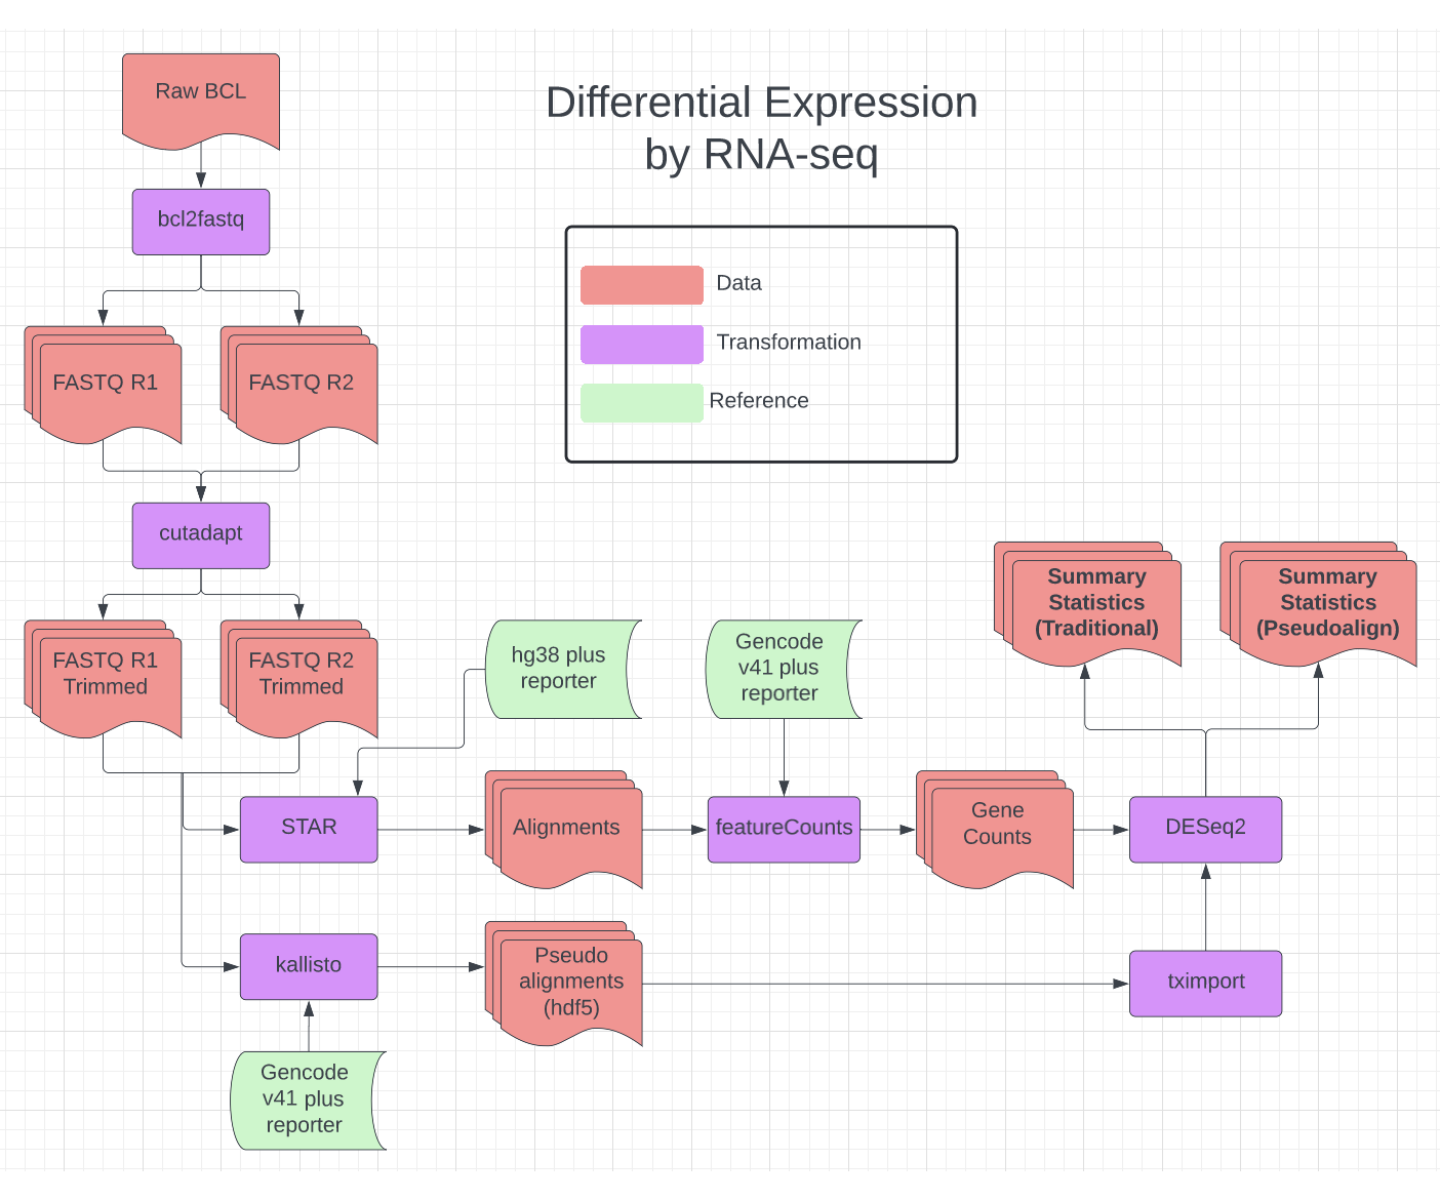

In [6]:
options(repr.plot.width = 12, repr.plot.height = 10)
img <- readPNG("../images/diff-exp-bioinfoflow.png")
grid::grid.raster(img)

### Differential Expression <a name="part3"></a>

Since it is more compatible with visual inspection and interpretation of results, the rest of this notebook uses the output of the "traditional" procedure using alignment and feature counting. To identify differentially expressed genes, we separate samples into groups by doxycycline concentration. Then, we can apply two possible modeling approaches to capture different kinds of effects. First, we can use a nested model structure which tests for significant cytokine effects in each genotype separately, while controlling for cytokine-independent differences in genotype groups. This model structure is shown below:

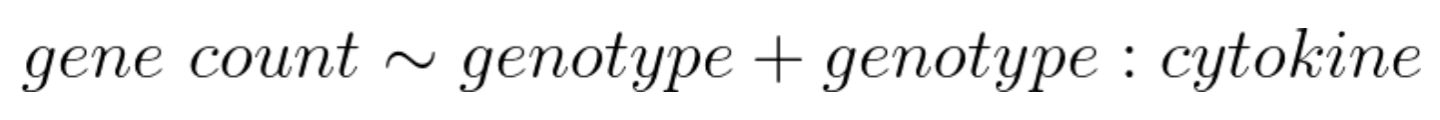

In [7]:
options(repr.plot.width = 12, repr.plot.height = 1)
img <- readPNG("../images/diff-exp-eq.png")
grid::grid.raster(img)

There are two types of comparisons we can make between sample groups:

1. First, we can test whether each gene is differentially expressed upon cytokine treatment in each genotype individually. We do this in a single model, and that model returns three sets of summary statistics that contain the fold changes upon cytokine treatment in each genotype, and the test against the null hypothesis that cytokine treated and untreated are equal.
2. Second, we can test whether the cytokine effect itself is different (a difference-of-differences) between genotypes. This secondary contrast returns two sets of summary statistics that compare the difference in cytokine-induced fold change between two genotypes, either WT vs P1104A or WT vs EFF.

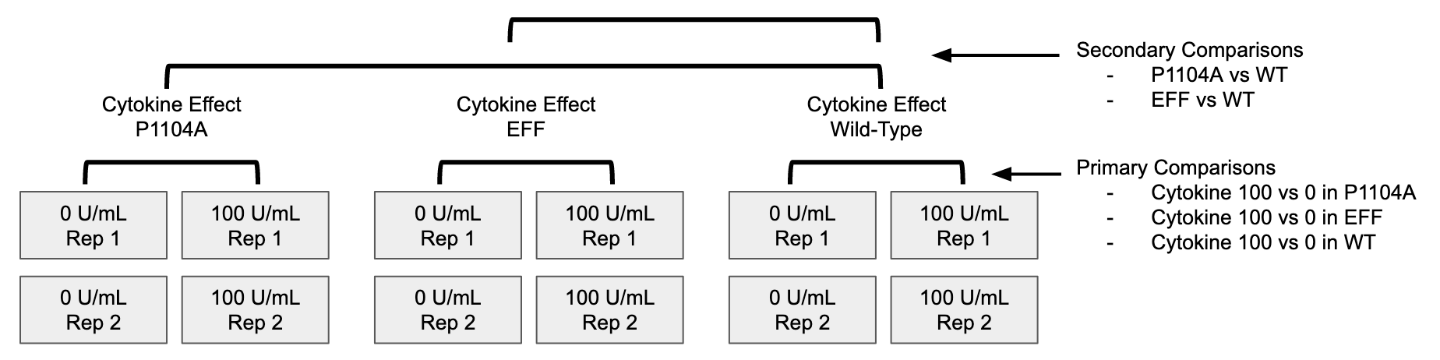

In [46]:
options(repr.plot.width = 12, repr.plot.height = 3)
img <- readPNG("../images/diff-exp-model-graphical.png")
grid::grid.raster(img)

In [23]:
files <- dir_ls("../pipeline/diffexp/",glob = "*counts.tsv")
names(files) <- gsub("../pipeline/diffexp/|.counts.tsv","",files)
data <- files %>% map_dfr(read_tsv, .id = "sample", skip = 2,
                          col_names = c("gene","chr","start","stop","strand","length","count"))

data_wide <- data %>%
    select(sample, gene, count) %>%
    group_by(gene) %>%
    #filter(sum(count >= 20) >= 2) %>%
    pivot_wider(names_from = sample, values_from = count)

sample_properties <- data %>% 
    select(sample) %>% 
    distinct() %>%
    separate(sample, c("group","dox","cyto","rep"), "_")

sample_properties$group <- relevel(as.factor(sample_properties$group), ref = "WT")

Rows: 60607 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): gene, chr, start, stop, strand
dbl (2): length, count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 60607 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): gene, chr, start, stop, strand
dbl (2): length, count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 60607 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): gene, chr, start, stop, strand
dbl (2): length, count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet 

In [25]:
data_wide %>%
    write_tsv("../pipeline/diffexp/counts.tsv")

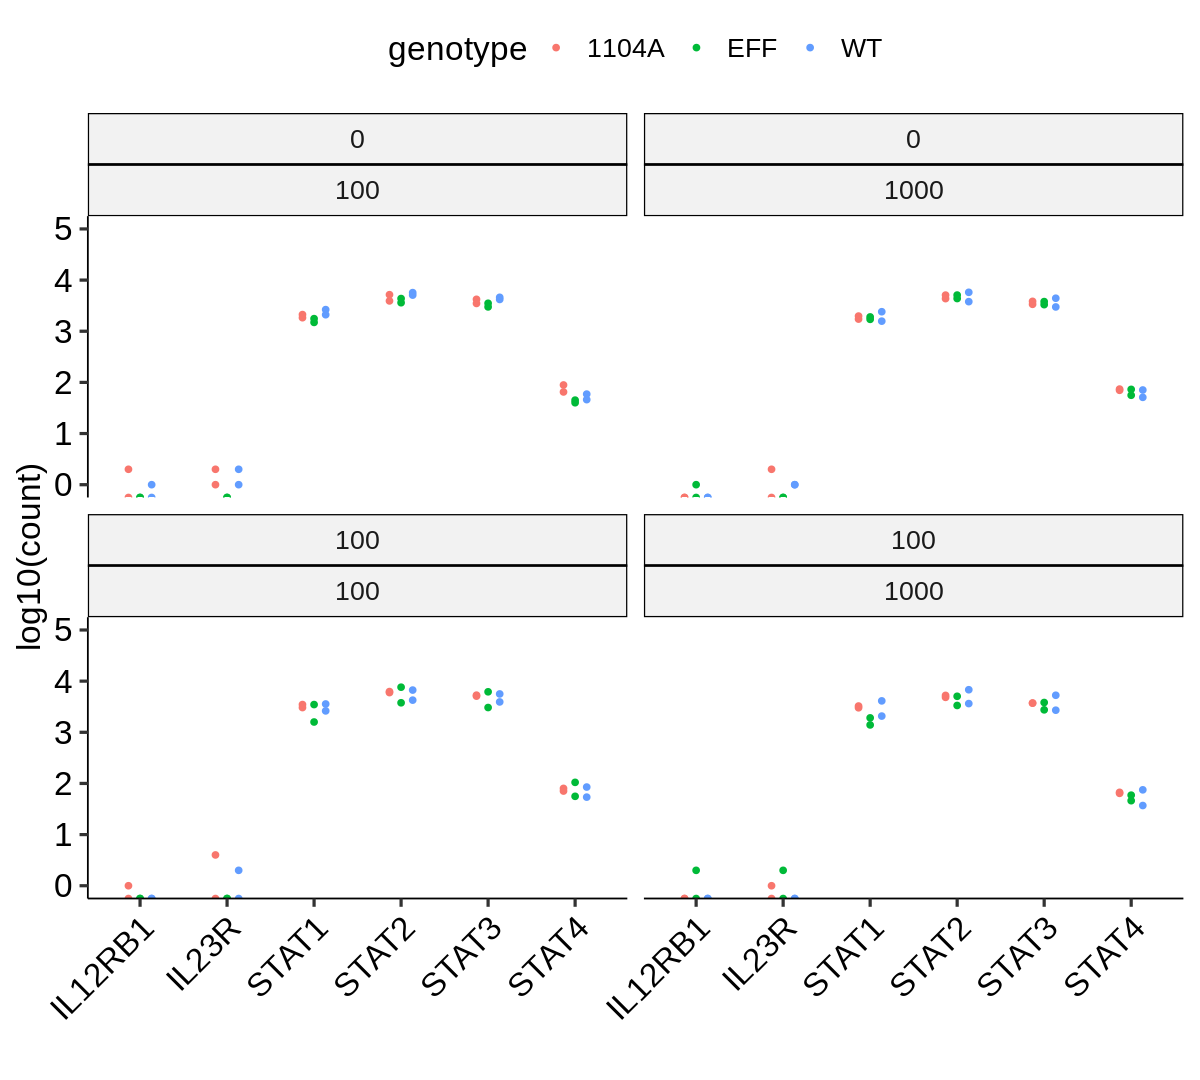

In [41]:
options(repr.plot.width = 10, repr.plot.height = 9)
data_wide %>%
    filter(gene %in% c("STAT1", "STAT2", "STAT3", "STAT4", "IL12RB1", "IL23R")) %>%
    pivot_longer(names_to = "sample", values_to = "count", 2:25) %>%
    separate(sample, c("genotype", "dox", "cytokine", "replicate")) %>%
    ggplot() +
        geom_point(aes(x = gene, y = log10(count), color = genotype), position = position_dodge(width = 0.4)) +
        theme_pubr(x.text.angle = 45, base_size = 20) +
        ylim(c(0,5)) +
        facet_wrap(~cytokine + dox) +
        xlab("")

In [ ]:
counts <- data_wide[,-1]

idx_100 <- which(sample_properties$dox == "100")
idx_1000 <- which(sample_properties$dox == "1000")

deobj_counts_100 <- DESeqDataSetFromMatrix(countData = counts[,idx_100],
    colData = sample_properties[-idx_100,],
    design = ~group+group:cyto)
deobj_counts_1000 <- DESeqDataSetFromMatrix(countData = counts[,idx_1000],
    colData = sample_properties[-idx_1000,],
    design = ~group+group:cyto)

deresult_100 <- DESeq(deobj_counts_100)
deresult_1000 <- DESeq(deobj_counts_1000)

In [6]:
sig_genes_contr_eff_100 <- as_tibble(results(deresult_100, contrast = c(0,0,0,-1,0,1), independentFiltering = FALSE)) %>%
    mutate(gene = data_wide$gene,
           padj = p.adjust(pvalue, method = "fdr"),
           doxy = 100)
sig_genes_contr_1104a_100 <- as_tibble(results(deresult_100, contrast = c(0,0,0,-1,1,0), independentFiltering = FALSE)) %>%
    mutate(gene = data_wide$gene,
           padj = p.adjust(pvalue, method = "fdr"),
           doxy = 100) 

sig_genes_contr_eff_1000 <- as_tibble(results(deresult_1000, contrast = c(0,0,0,-1,0,1), independentFiltering = FALSE)) %>%
    mutate(gene = data_wide$gene,
           padj = p.adjust(pvalue, method = "fdr"),
           doxy = 1000)
sig_genes_contr_1104a_1000 <- as_tibble(results(deresult_1000, contrast = c(0,0,0,-1,1,0), independentFiltering = FALSE)) %>%
    mutate(gene = data_wide$gene,
           padj = p.adjust(pvalue, method = "fdr"),
           doxy = 1000)

sig_genes_100 <- bind_rows(sig_genes_contr_eff_100, sig_genes_contr_1104a_100) %>%
    filter(padj < 0.01 & gene != "ENSG00000197149") %>% # likely false positive ribosomal protein psedogene
    select(gene) %>% unlist()
sig_genes_1000 <- bind_rows(sig_genes_contr_eff_1000, sig_genes_contr_1104a_1000) %>%
    filter(padj < 0.01) %>%
    select(gene) %>% unlist()

In [7]:
coefs <- resultsNames(deresult_100)[4:6]

for(cf in coefs){
    
    doxy100 <- as_tibble(results(deresult_100, name = cf)) %>% 
        mutate(gene = data_wide$gene,
               doxy = 100)
    doxy1000 <- as_tibble(results(deresult_1000, name = cf)) %>% 
        mutate(gene = data_wide$gene,
               doxy = 1000)
    alldata <- bind_rows(doxy100,doxy1000)
    write_tsv(alldata,paste0("../sumstats/diffexp/Tyk2-DE-",cf,".tsv.gz"))
    
}

bind_rows(sig_genes_contr_eff_100, sig_genes_contr_eff_1000) %>%
    write_tsv(paste0("../sumstats/diffexp/Tyk2-DE-EFFvsWT.tsv.gz"))
bind_rows(sig_genes_contr_1104a_100, sig_genes_contr_1104a_1000) %>%
    write_tsv(paste0("../sumstats/diffexp/Tyk2-DE-P1104AvsWT.tsv.gz"))

### Primary Results: Cytokine Effects Within Each Genotype <a name="part4"></a>

There are a lot of different questions we can ask of these summary statistics, but the "primary" comparison is the cytokine response of each gene within each genotype. If we control the false discovery rate to 1%, we obtain the following numbers of significantly differentially expressed genes upon cytokine treatment in each condition:

In [ ]:
comp_explain <- tibble("comparison" = sumstats %>% select(comparison) %>% distinct() %>% unlist(),
                       "explanation" = c("Cytokine Effect in EFF",
                                         "Cytokine Effect in P1104A",
                                         "Cytokine Effect in WT",
                                         "Difference in Cytokine Effect Between WT and EFF",
                                         "Difference in Cytokine Effect Between WT and P1104A"))

sumstats_files <- dir_ls("../sumstats/diffexp/", glob = "*.tsv.gz") 
names(sumstats_files) <- gsub("../sumstats/diffexp/Tyk2-DE-|.tsv.gz","",sumstats_files,perl=T)
sumstats <- sumstats_files %>% map_dfr(read_tsv, .id = "comparison") %>% left_join(comp_explain)

sumstats_primary <- sumstats %>% filter(!grepl("Difference",explanation))

In [ ]:
deg_counts <- sumstats_primary %>%
    group_by(comparison, doxy) %>%
    summarize(DEG_count = sum(padj <= 0.01, na.rm = T)) %>%
    left_join(comp_explain) %>%
    ungroup() %>%
    select(-comparison)

In [15]:
deg_counts

doxy,DEG_count,explanation
<dbl>,<int>,<chr>
100,16,Cytokine Effect in EFF
1000,0,Cytokine Effect in EFF
100,11,Cytokine Effect in P1104A
1000,46,Cytokine Effect in P1104A
100,11,Cytokine Effect in WT
1000,518,Cytokine Effect in WT


#### Luciferase <a name="part4a"></a>

We can visualize the expression of the luciferase reporter in two ways. First, we can just plot the summary statistics, showing the effect size and confidence interval from each comparison. Second, we can extract and plot the normalized expression values directly.

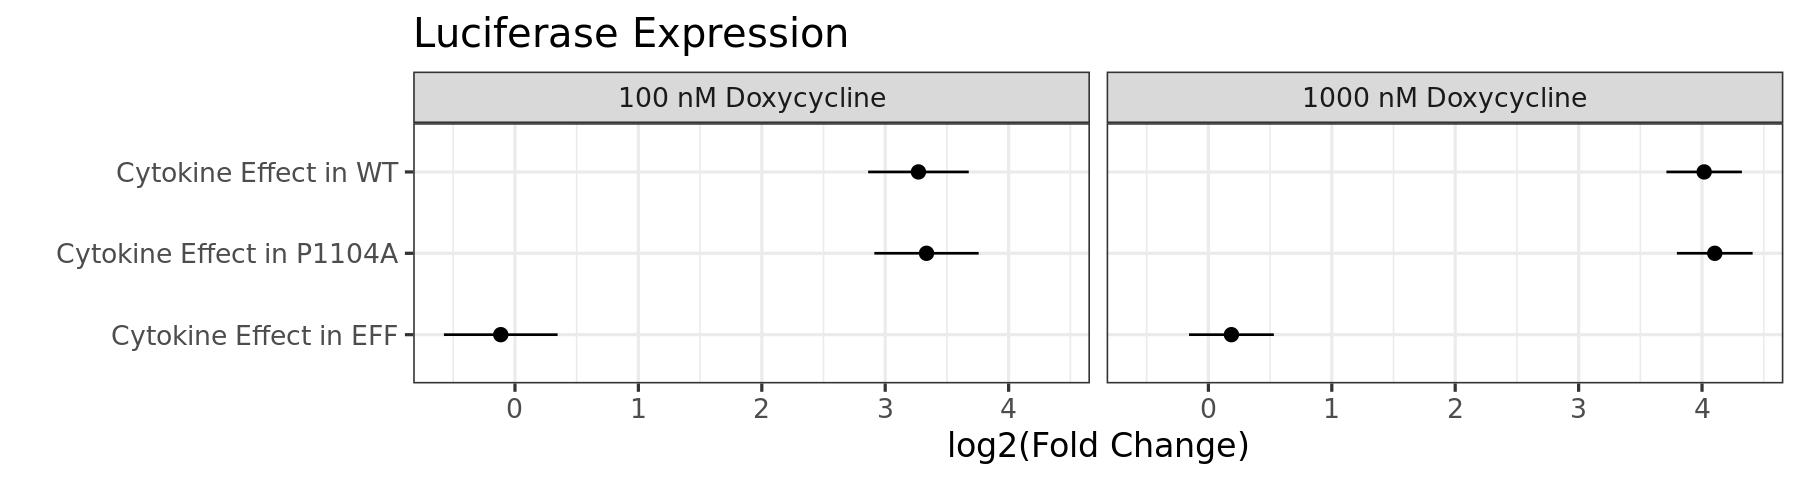

In [17]:
options(repr.plot.height = 4, repr.plot.width = 15)
sumstats %>%
    filter(gene == "Luciferase") %>%
    mutate(doxy = if_else(doxy == 100, "100 nM Doxycycline","1000 nM Doxycycline")) %>%
    filter(!grepl("Difference",explanation)) %>%
    ggplot() +
        geom_pointrange(aes(x = log2FoldChange,
                            xmin = log2FoldChange-(3*lfcSE),
                            xmax = log2FoldChange+(3*lfcSE),
                            y = explanation),size=0.75) +
        theme_bw(base_size = 20) + 
        facet_wrap(~doxy, ncol = 2) + 
        xlab("log2(Fold Change)") + ylab("") +
        ggtitle("Luciferase Expression")

The cytokine effect results in an approximately 10-16 fold change in luciferase in WT and P1104A, but not in EFF. There is no significant difference between genotypes on average, separate from the cytokine effect. While we could formally test whether there is a significant difference between the WT and P1104A effects, there is no real need to do so since the intervals are nearly identical.

We can also extract and plot the normalized expression of luciferase directly in each sample. These are the log2(counts per million):

In [ ]:
sfactors <- tibble(sizeFactor = c(deresult_100$sizeFactor, deresult_1000$sizeFactor),
                   sample = c(names(deresult_100$sizeFactor),names(deresult_1000$sizeFactor)))

normcounts <-  data %>%
    inner_join(sfactors) %>%
    group_by(sample) %>%
    mutate(expr = log2(count/sizeFactor)) %>%
    select(sample, gene, expr) %>%
    separate("sample",c("genotype","doxycycline","cytokine","rep"),"_")

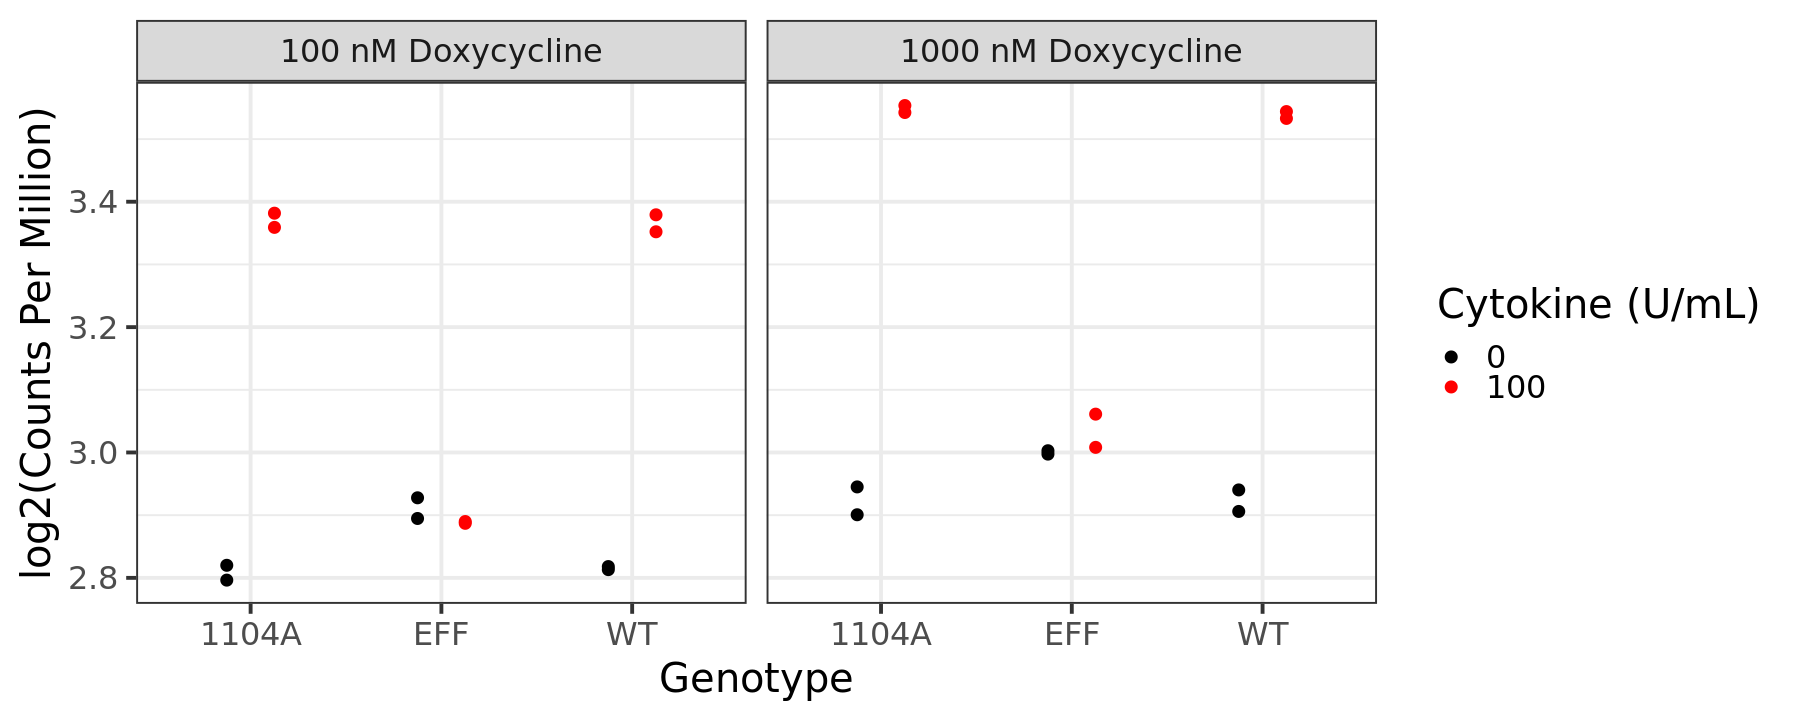

In [45]:
options(repr.plot.height = 6, repr.plot.width = 15)
normcounts %>%
    filter(gene == "Luciferase") %>%
    mutate(doxycycline = if_else(doxycycline == 100, "100 nM Doxycycline", "1000 nM Doxycycline")) %>%
    ggplot() +
        geom_point(aes(x =genotype, y = log2(expr), group = cytokine,
                       color = as.factor(cytokine)),position = position_dodge(width=0.5), size = 3) +
        facet_wrap(~doxycycline) +
        theme_bw(base_size = 24) +
        scale_color_manual(values = c("0" = "black", "100" = "red"), name = "Cytokine (U/mL)") +
        ylab("log2(Counts Per Million)") + xlab("Genotype")

#### Pathway Components <a name="part4b"></a>

Beyond luciferase, we are particularly interested in the relative expression of TYK2, JAK1, STAT1, STAT2, IFNAR1, IFNAR2, and IRF9. We extract the same normalized counts as above as `log2(counts per million)` and plot them as a grid from each doxycycline concentration. Note: these values are plotted regardless of whether the gene is expressed sufficiently for differential testing. For example, `IRF9` has far fewer than the required counts per sample for testing but is plotted below for comparison:

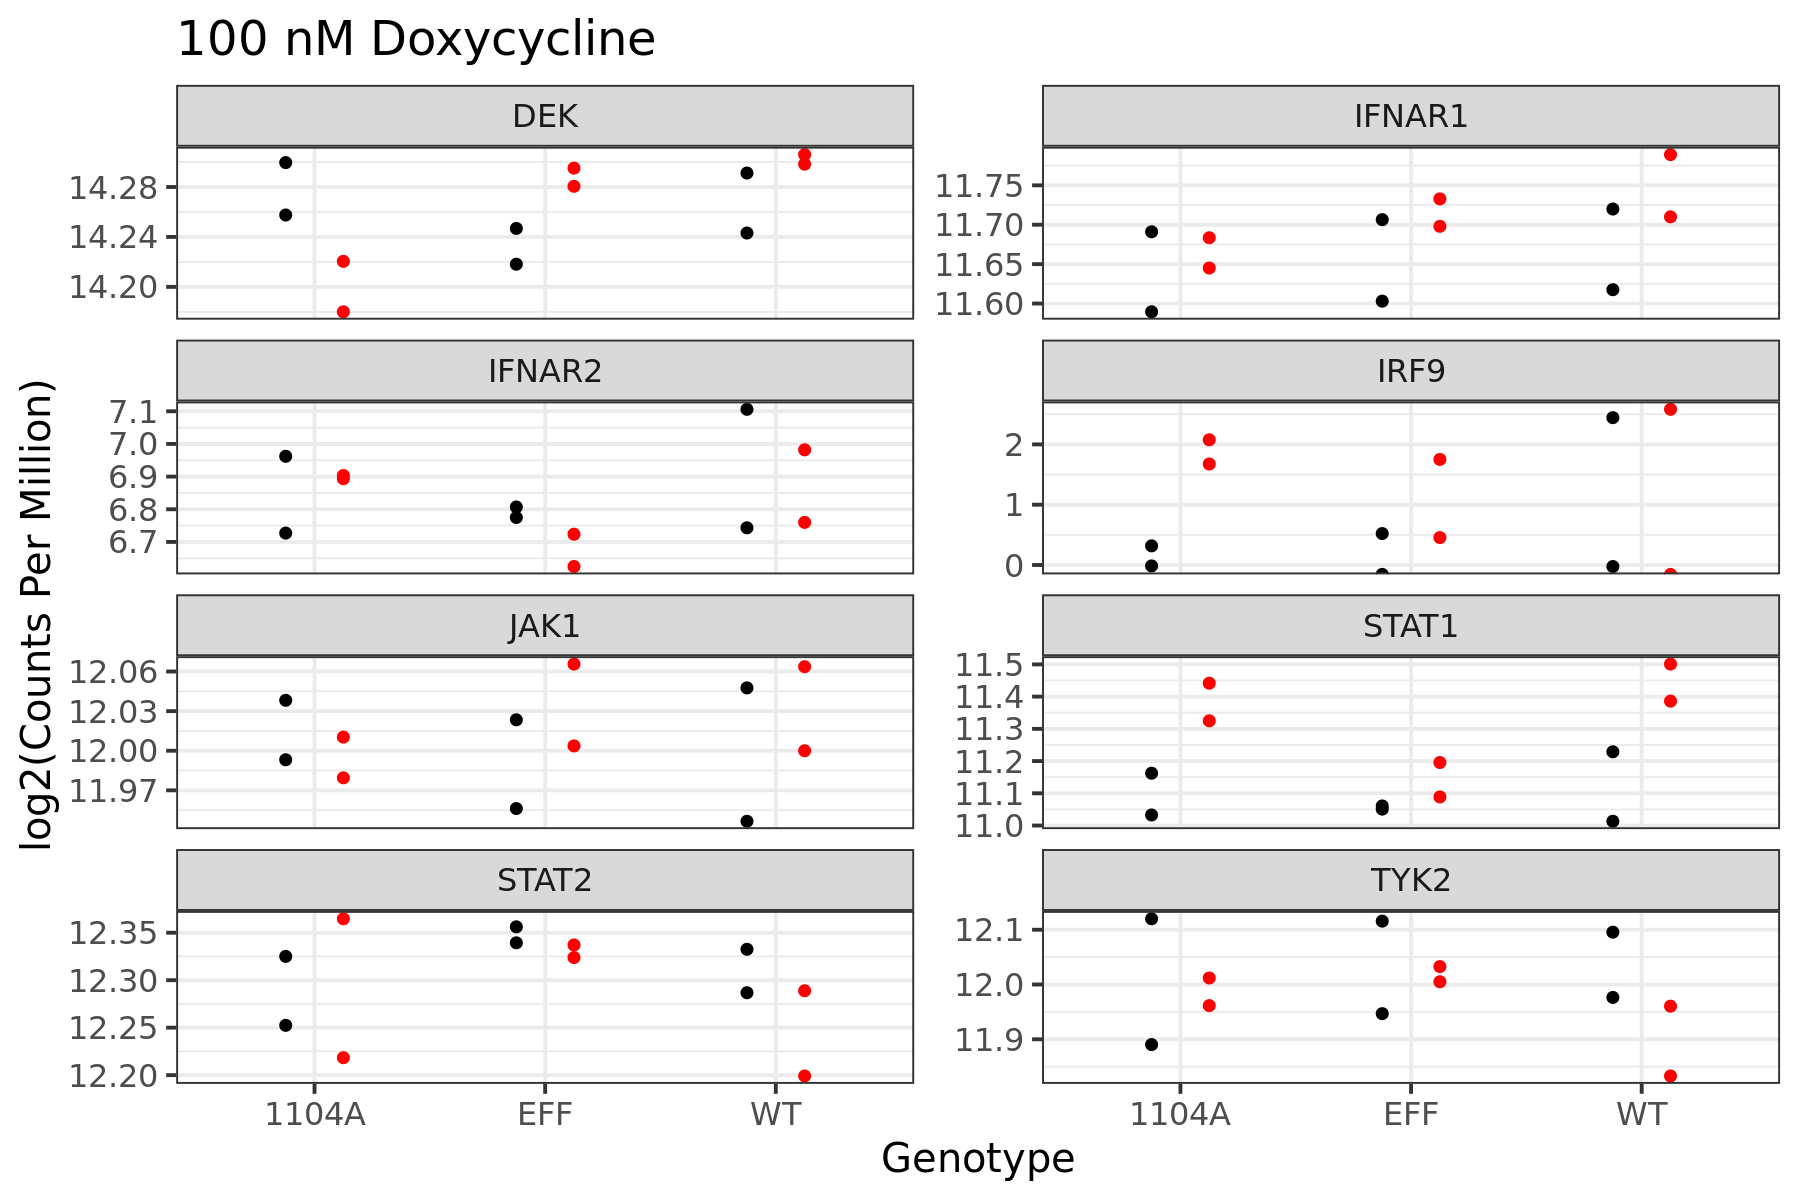

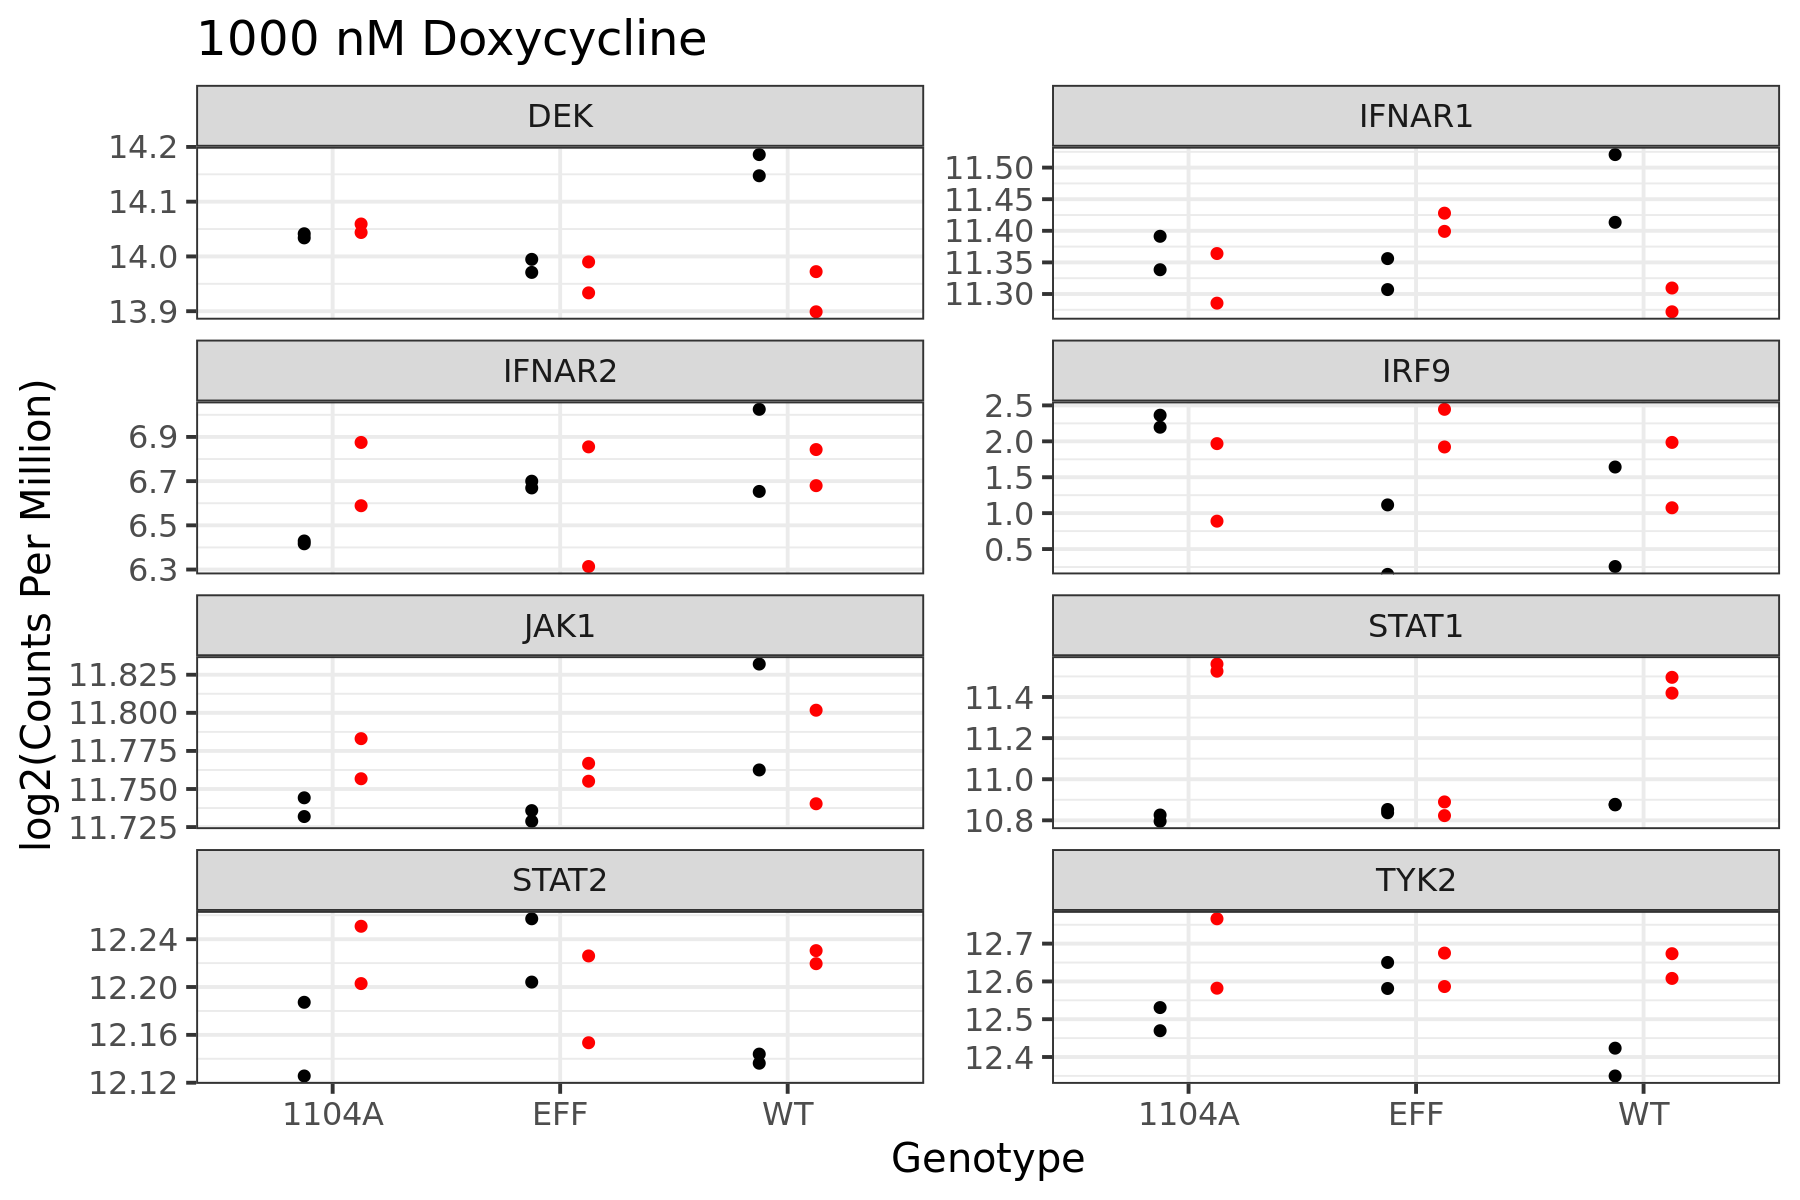

In [49]:
genes <- c("TYK2","JAK1","STAT1","STAT2","IFNAR1","IFNAR2","IRF9","DEK")

options(repr.plot.height = 10, repr.plot.width = 15)
normcounts %>%
    filter(gene %in% genes) %>%
    filter(doxycycline == 100) %>%
    mutate(doxycycline = if_else(doxycycline == 100, "100 nM Doxycycline", "1000 nM Doxycycline")) %>%
    ggplot() +
        geom_point(aes(x =genotype, y = expr, group = cytokine,
                       color = as.factor(cytokine)),position = position_dodge(width=0.5), size = 3) +
        facet_wrap(~gene, scales = "free_y", ncol = 2) +
        theme_bw(base_size = 24) +
        theme(legend.position = "none") +
        scale_color_manual(values = c("0" = "black", "100" = "red"), name = "Cytokine (U/mL)") +
        ylab("log2(Counts Per Million)") + xlab("Genotype") +
        ggtitle("100 nM Doxycycline")

normcounts %>%
    filter(gene %in% genes) %>%
    filter(doxycycline == 1000) %>%
    mutate(doxycycline = if_else(doxycycline == 100, "100 nM Doxycycline", "1000 nM Doxycycline")) %>%
    ggplot() +
        geom_point(aes(x =genotype, y = expr, group = cytokine,
                       color = as.factor(cytokine)),position = position_dodge(width=0.5), size = 3) +
        facet_wrap(~gene, scales = "free_y", ncol = 2) +
        theme_bw(base_size = 24) +
        theme(legend.position = "none") +
        scale_color_manual(values = c("0" = "black", "100" = "red"), name = "Cytokine (U/mL)") +
        ylab("log2(Counts Per Million)") + xlab("Genotype") +
        ggtitle("1000 nM Doxycycline")

#### Volcano Plots <a name="part4c"></a>

In volcano plots, the unadjusted p-value is transformed (negative log) such that higher means more significant, and then plotted relative to the estimated log2 fold change. Luciferase clearly jumps out, but we also see some elevation of pathway components namely STAT1. EFF is entirely flat, while P1104A and WT have a similar structure:

In [22]:
min_nonzero_p <- sumstats_primary %>% 
    select(pvalue) %>% 
    filter(pvalue > 0) %>% 
    summarize(min(pvalue)) %>% 
    unlist()

sumstats_primary$pvalue[which(sumstats_primary$pvalue == 0)] <- min_nonzero_p

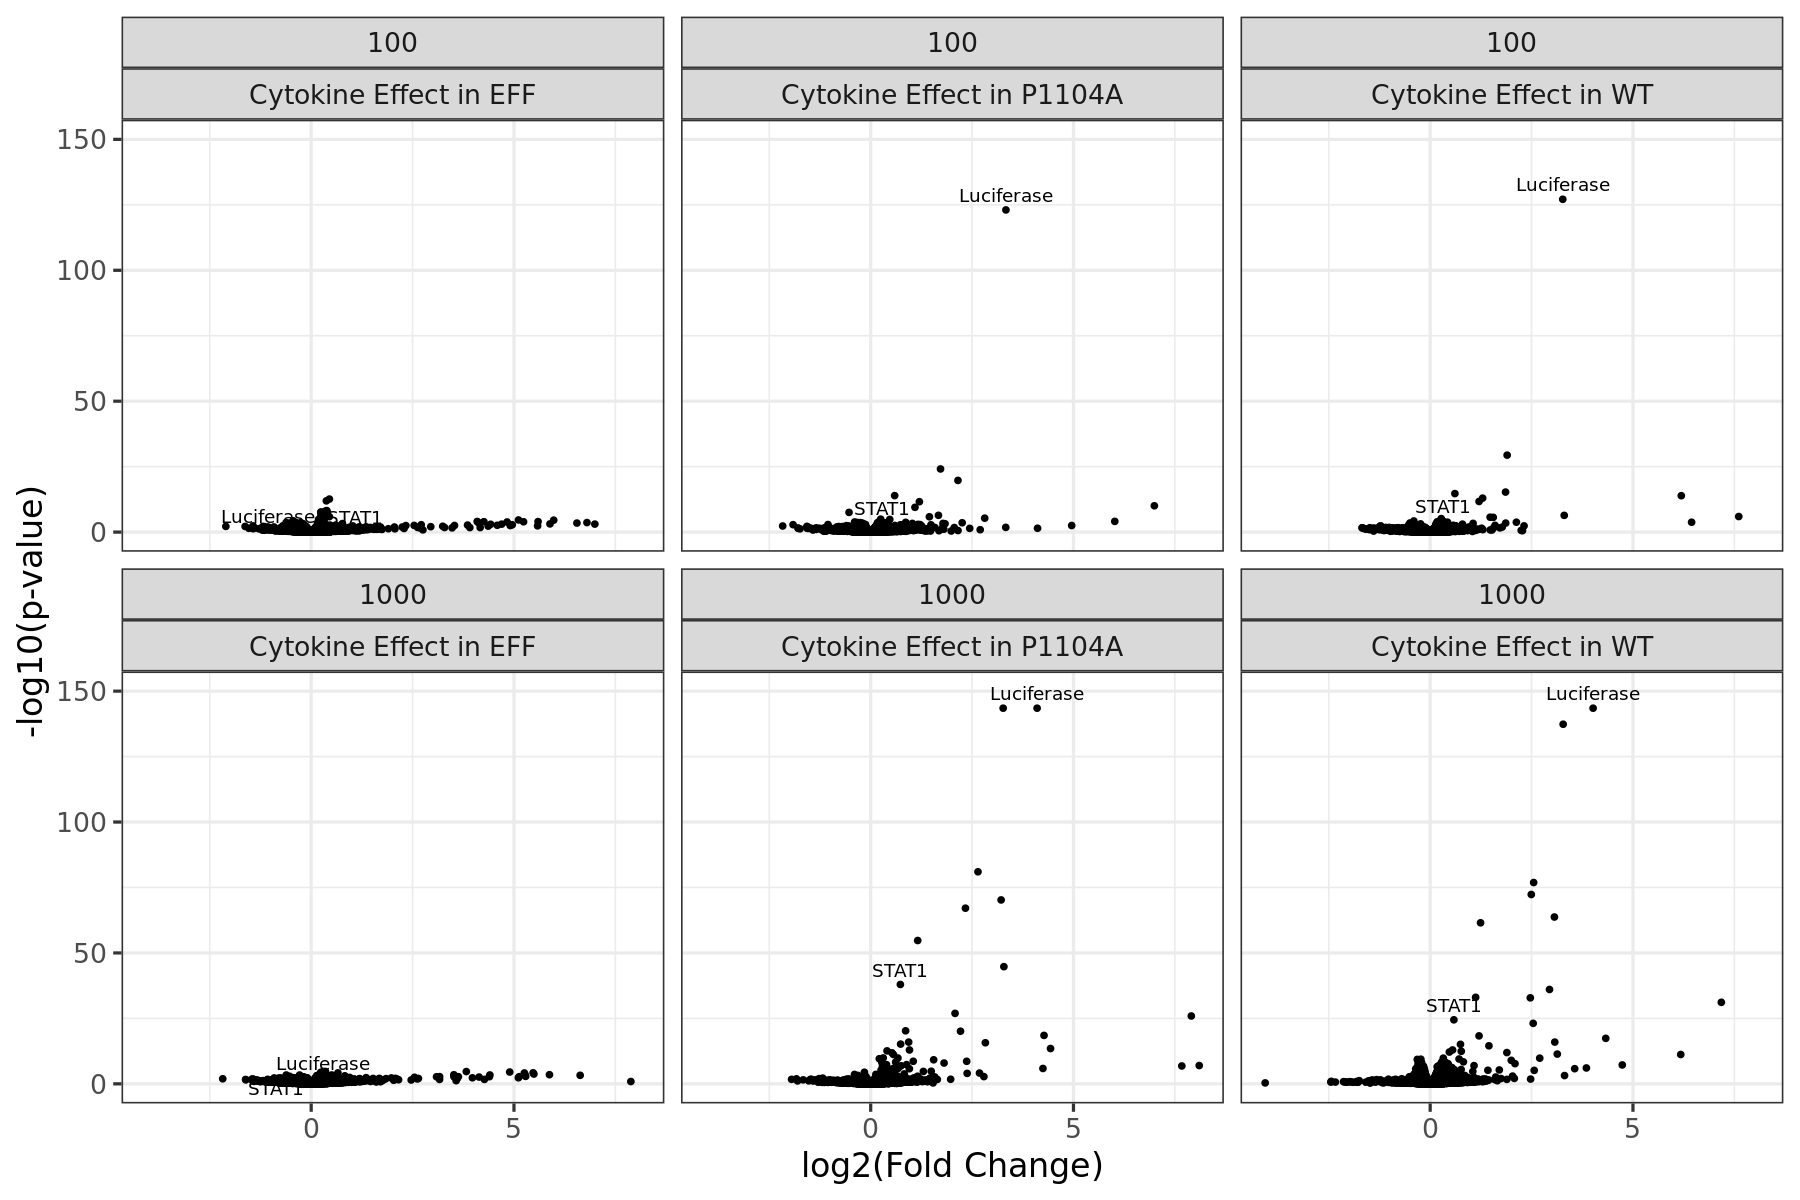

In [23]:
library(ggrepel)
sumstats_primary %>%
    filter(is.finite(pvalue)) %>%
    ggplot() +
        geom_point(aes(x = log2FoldChange, y = -log10(pvalue))) +
        geom_text_repel(data = sumstats_primary %>% filter(gene %in% c("Luciferase","STAT1")),
                         aes(x = log2FoldChange, y = -log10(pvalue), label = gene), nudge_y = 5) +
        theme_bw(base_size = 20) +
        facet_wrap(~doxy + explanation) + 
        ylim(c(0,150)) + 
        xlab("log2(Fold Change)") + ylab("-log10(p-value)")

### Secondary Results: Comparing Cytokine Effects Between Genotypes <a name="part5"></a>

In the above plots, we quantified the effects of cytokine in each genotype indidually. However, we are most interested in the genes whose cytokine response is different between genotypes. So we computed the secondary comparisons of EFF vs WT and P1104A vs WT, and tested for whether the cytokine effect itself in each genotype was equal. For both 100 nM and 1000 nM doxycycline, there were zero significantly different genes in the P1104A vs WT comparison, while there were 6 and 70 for EFF respectively.

#### Heatmaps <a name="part5a"></a>

The easiest way to view all of these genes together is with a heatmap. These plots show the cytokine ("primary") log2(Fold Change) for each gene in each genotype, but subset to only show the genes with significant differences between either EFF vs WT or P1104A vs WT ("secondary").

In [31]:
sigstats_100 <- sumstats_primary %>%
    filter(doxy == 100 & gene %in% sig_genes_100 & gene != "ENSG00000197149") %>%
    select(log2FoldChange, gene, comparison) %>%
    pivot_wider(names_from = comparison, values_from = log2FoldChange)

sigstats_1000 <- sumstats_primary %>%
    filter(doxy == 1000 & gene %in% sig_genes_1000) %>%
    select(log2FoldChange, gene, comparison) %>%
    pivot_wider(names_from = comparison, values_from = log2FoldChange)

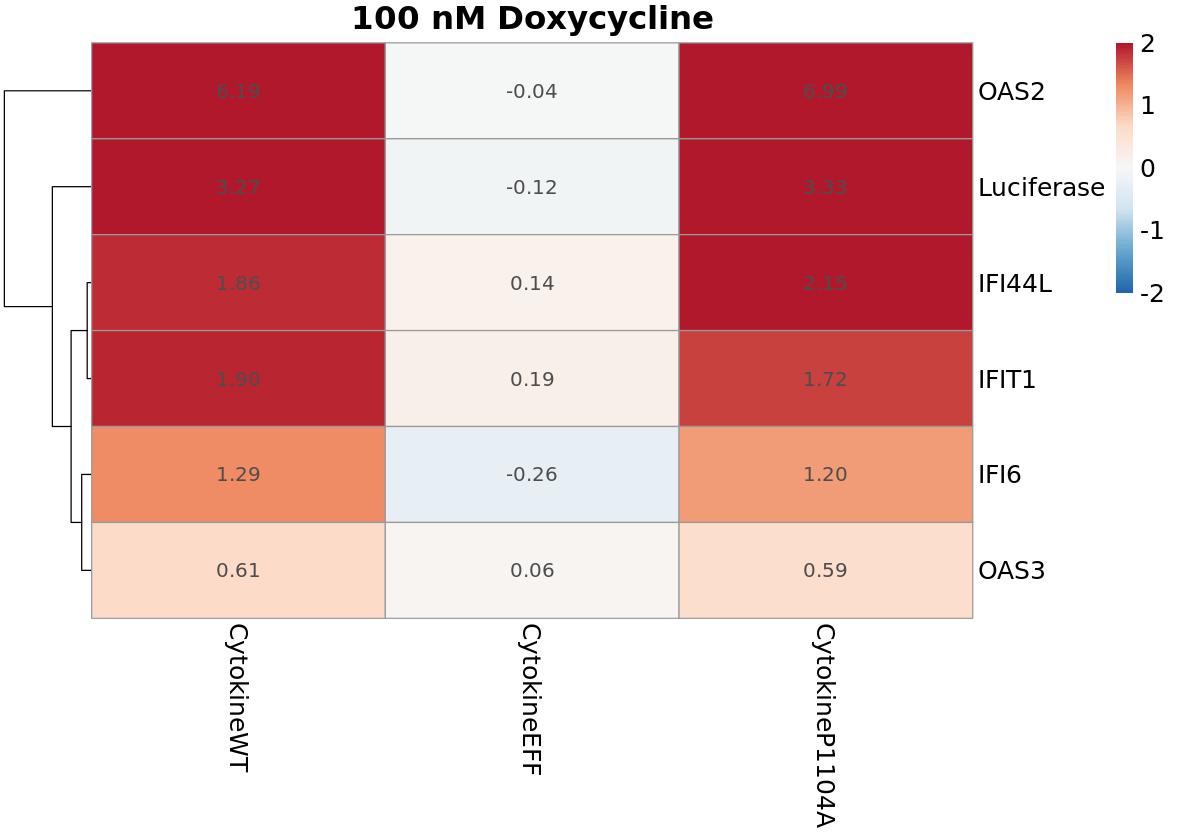

In [ ]:
options(repr.plot.height = 7, repr.plot.width = 10)

myBreaks <- c(seq(-2, 0, length.out=ceiling(100/2) + 1), 
              seq(5/100, 2, length.out=floor(100/2)))

pheatmap(sigstats_100[,c(4,2,3)],
         display_numbers = T,
         cluster_cols = FALSE,
         show_rownames = TRUE,
         labels_row = sigstats_100$gene,
         fontsize = 15,
         main = "100 nM Doxycycline",
         color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdBu")))(100),
         breaks = myBreaks,
         clustering_distance_rows = "euclidean")

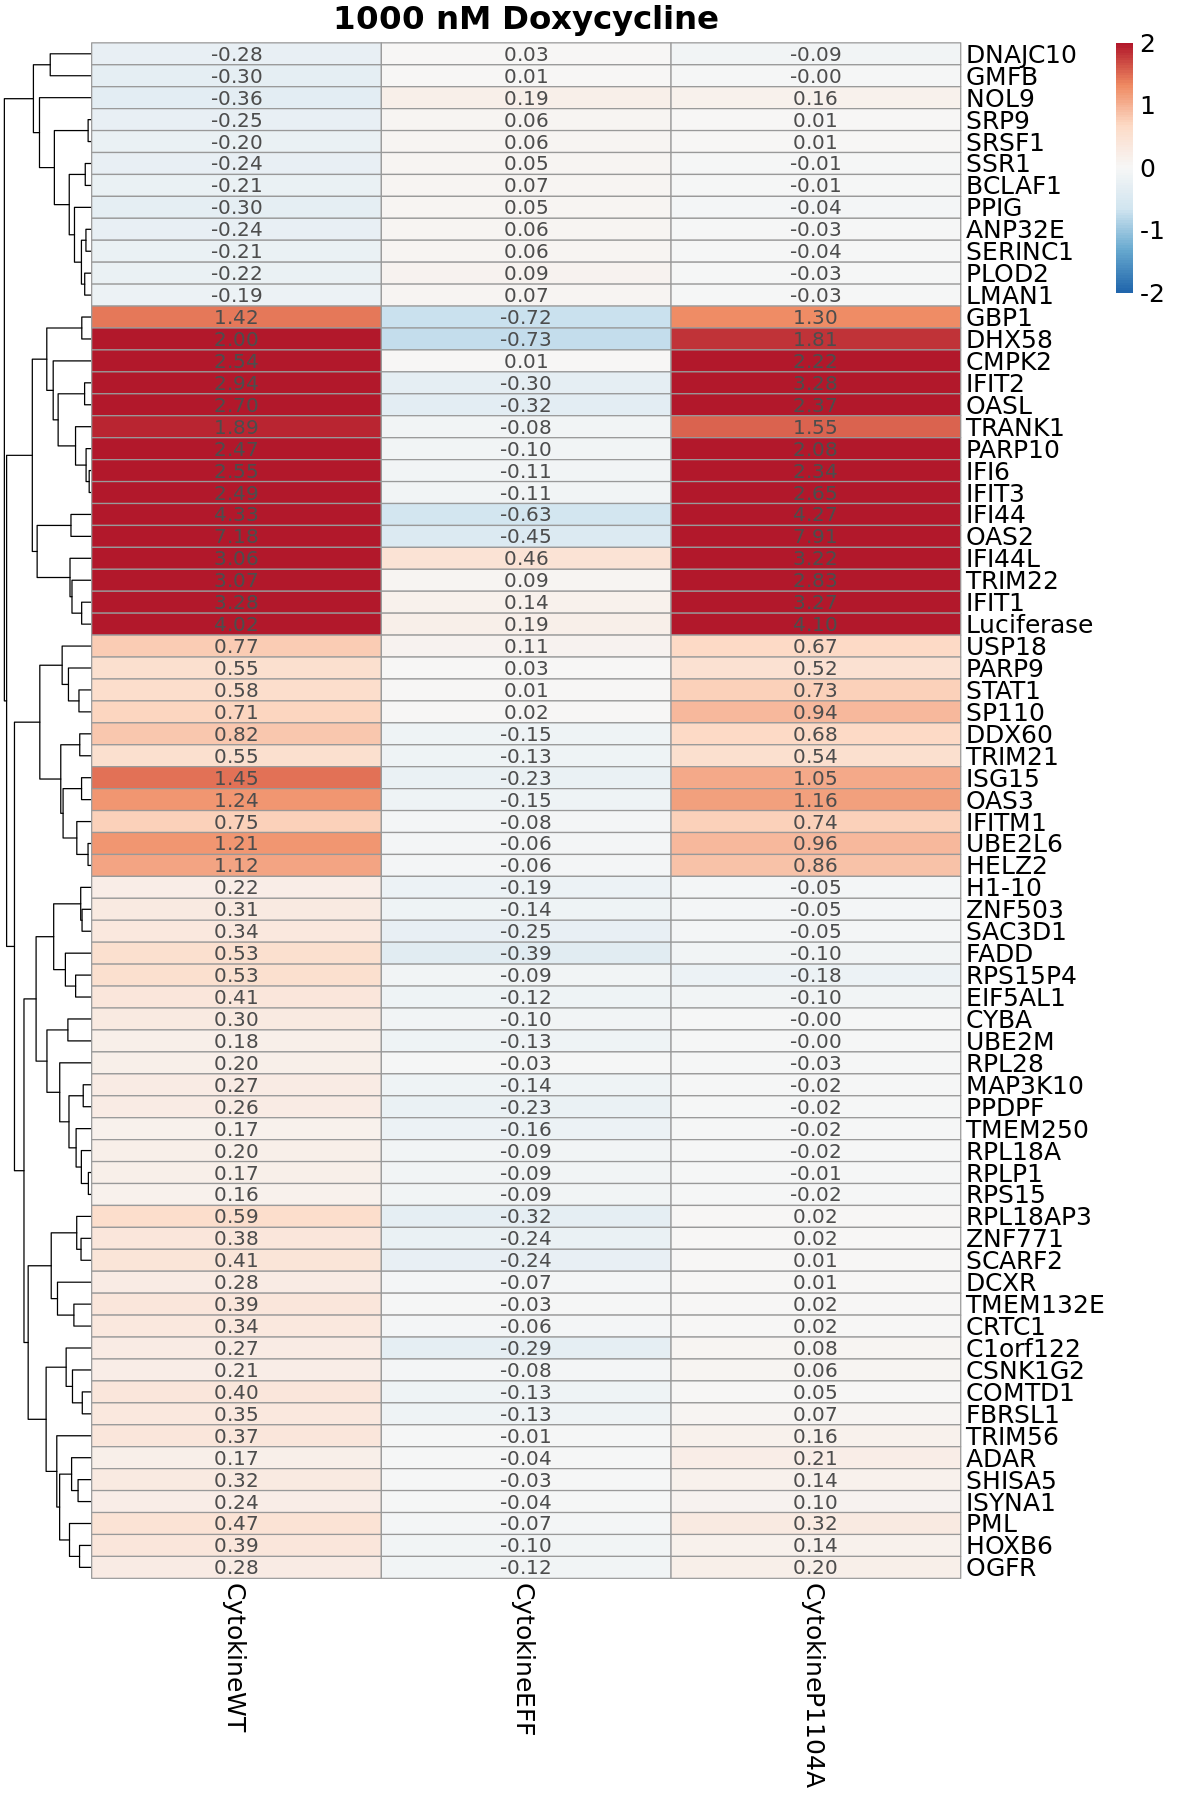

In [ ]:
options(repr.plot.height = 15, repr.plot.width = 10)

pheatmap(sigstats_1000[,c(4,2,3)],
         display_numbers = T,
         cluster_cols = FALSE,
         show_rownames = TRUE,
         labels_row = sigstats_1000$gene,
         fontsize = 15,
         main = "1000 nM Doxycycline",
         color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdBu")))(100),
         breaks = myBreaks,
         clustering_distance_rows = "canberra")